# VIX

In [2]:
import pandas as pd

df = pd.read_csv('VIX_History.csv')
df['DATE'] = pd.to_datetime(df['DATE'])

df['YearMonth'] = df['DATE'].dt.to_period('M')
first_trade_days = df.groupby('YearMonth').first().reset_index()[['YearMonth', 'DATE']]

month_high = df.groupby('YearMonth')['HIGH'].max()

df['Actual_Highest'] = None
for _, row in first_trade_days.iterrows():
    month = row['YearMonth']
    date = row['DATE']
    max_high = month_high[month]
    df.loc[df['DATE'] == date, 'Actual_Highest'] = max_high

prev_month_high = month_high.shift(1)
df['Predicted_Highest'] = df['YearMonth'].map(prev_month_high)

df.drop(columns=['YearMonth'], inplace=True)
print(df.head(40))

         DATE   OPEN   HIGH    LOW  CLOSE Actual_Highest  Predicted_Highest
0  1990-01-02  17.24  17.24  17.24  17.24          27.25                NaN
1  1990-01-03  18.19  18.19  18.19  18.19           None                NaN
2  1990-01-04  19.22  19.22  19.22  19.22           None                NaN
3  1990-01-05  20.11  20.11  20.11  20.11           None                NaN
4  1990-01-08  20.26  20.26  20.26  20.26           None                NaN
5  1990-01-09  22.20  22.20  22.20  22.20           None                NaN
6  1990-01-10  22.44  22.44  22.44  22.44           None                NaN
7  1990-01-11  20.05  20.05  20.05  20.05           None                NaN
8  1990-01-12  24.64  24.64  24.64  24.64           None                NaN
9  1990-01-15  26.34  26.34  26.34  26.34           None                NaN
10 1990-01-16  24.18  24.18  24.18  24.18           None                NaN
11 1990-01-17  24.16  24.16  24.16  24.16           None                NaN
12 1990-01-1

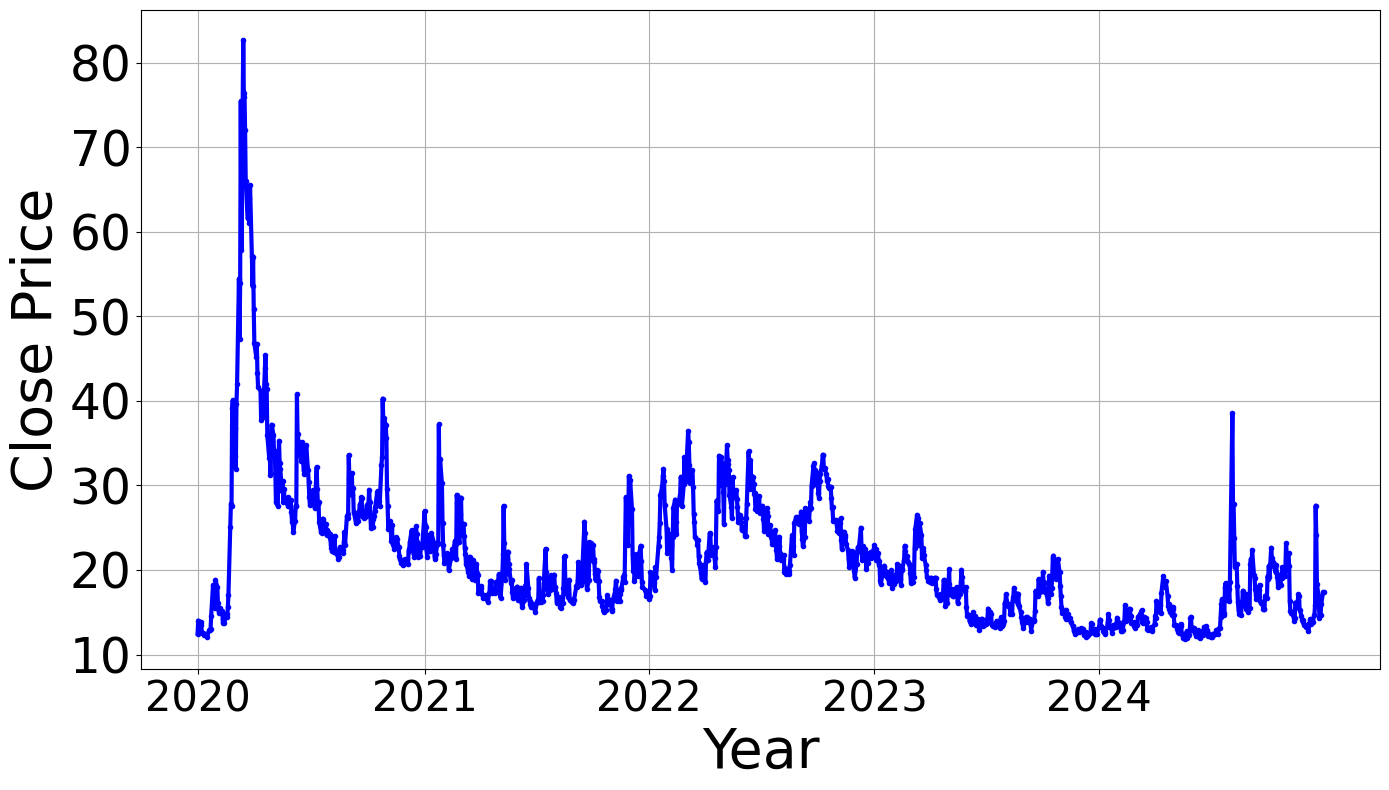

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

mask = (df['DATE'] >= '2020-01-01') & (df['DATE'] <= '2024-12-31')
df_filtered = df.loc[mask].copy()

xtick_dates = []
for year in range(2020, 2025):
    target_date = pd.to_datetime(f'{year}-01-01')
    candidate = df_filtered[df_filtered['DATE'] >= target_date]
    if not candidate.empty:
        xtick_dates.append(candidate.iloc[0]['DATE'])

plt.figure(figsize=(14, 8))
plt.plot(df_filtered['DATE'], df_filtered['CLOSE'], color='blue', linewidth=3, marker='o', markersize=3)

xtick_labels = [d.strftime('%Y') for d in xtick_dates]
plt.xticks(ticks=xtick_dates, labels=xtick_labels, fontsize=30, rotation=0)

plt.xlabel('Year', fontsize=40)
plt.ylabel('Close Price', fontsize=40)
plt.yticks(fontsize=35)
plt.grid(True)
plt.tight_layout()
plt.savefig(
    '/Users/sizheli/Desktop/price.pdf',
    format='pdf',
    bbox_inches='tight'
)
plt.show()

In [12]:
df['DATE'] = pd.to_datetime(df['DATE'], format='%m/%d/%Y')

df_filtered = df[(df['DATE'] >= '2020-01-01') & (df['DATE'] < '2025-01-01')].copy()
df_filtered['Group'] = ((df_filtered['DATE'].dt.year - 2020) * 12 + df_filtered['DATE'].dt.month)

print(df_filtered.head())

           DATE   OPEN   HIGH    LOW  CLOSE Actual_Highest  Predicted_Highest  \
7556 2020-01-02  13.46  13.72  12.42  12.47          19.99              17.99   
7557 2020-01-03  15.01  16.20  13.13  14.02           None              17.99   
7558 2020-01-06  15.45  16.39  13.54  13.85           None              17.99   
7559 2020-01-07  13.84  14.46  13.39  13.79           None              17.99   
7560 2020-01-08  15.16  15.24  12.83  13.45           None              17.99   

      Group  
7556      1  
7557      1  
7558      1  
7559      1  
7560      1  


In [13]:
L = df_filtered['LOW'].min()
U = df_filtered['HIGH'].max()

print(f"L = {L}")
print(f"U = {U}")

L = 10.62
U = 85.47


### Different Learning-Augmented Algorithms

In [14]:
def blindly_trust(L, U, y):
    threshold = y
    return threshold

In [15]:
def El_Yaniv(L, U, y):
    threshold = (L * U) ** (1/2)
    return threshold

In [16]:
def Sun(L, U, y, lambda_):
    theta = U / L
    consistency = (2 * lambda_ * theta) / ( ((1 - lambda_) ** 2 + 4 * lambda_ *  theta) ** (1/2) - (1 - lambda_))
    robustness = theta / consistency
    if y < L * consistency:
        threshold = L * consistency
    elif y < L * robustness:
        threshold = lambda_ * L * robustness + (1 - lambda_) * y / consistency
    else:
        threshold = L * robustness
    return threshold

In [17]:
def Benomar(L, U, y, lambda_):
    theta = U / L
    consistency = (2 * lambda_ * theta) / ( ((1 - lambda_) ** 2 + 4 * lambda_ *  theta) ** (1/2) - (1 - lambda_))
    robustness = theta / consistency
    if y < L * consistency:
        threshold = L * consistency
    elif y < L * robustness:
        threshold = lambda_ * L * robustness + (1 - lambda_) * y / consistency
    else:
        threshold = L * robustness * (lambda_ + (1 - lambda_)/consistency) + ((y - L * robustness)/(U - L * robustness)) * (L * robustness - L * robustness * (lambda_ + (1 - lambda_) / consistency))
    return threshold

In [18]:
def epsilon_Tolerant(L, U, y, lambda_, eps):
    M = lambda_ * (L + 3 * eps) + (1 - lambda_) * ((L * U) ** (1/2) - eps)
    if y <= M - 2 * eps:
        threshold = (L * U) ** (1/2)
    elif y < M:
        threshold = M - eps
    elif y <= (L * U) ** (1/2) + eps:
        threshold = y - eps
    elif y < U - eps:
        mu = ((U - 2 * eps) - (L * U) / (M - eps)) / ((U - 2 * eps) - (L * U) ** (1/2))
        threshold = mu * (L * U) ** (1/2) + (1 - mu) * (y - eps)
    else:
        threshold = (L * U) / (M - eps)
    return threshold

### Online Decision Making

In [19]:
def extract_predicted_first(df):
    
    predicted_first = df.groupby('Group').head(1)['Predicted_Highest'].tolist()
    return predicted_first

predicted_first = extract_predicted_first(df_filtered)
print(predicted_first[1:6])

def extract_actual_first(df):

    actual_first = df.groupby('Group').head(1)['Actual_Highest'].tolist()
    return_actual = []
    for i in actual_first:
        j = float(i)
        return_actual.append(j)
    return return_actual
actual_first = extract_actual_first(df_filtered)

print(actual_first[1:6])

def adjust(error_level, predicted, actual):
    adjusted_predictions = []
    for i in range(0, len(predicted)):
        adjusted_prediction = error_level * predicted[i] + (1 - error_level) * actual[i]
        adjusted_predictions.append(adjusted_prediction)
    return adjusted_predictions

adjusted_predictions = adjust(0.1, predicted_first, actual_first)
print(adjusted_predictions[1:6])

[19.99, 49.48, 85.47, 60.59, 40.32]
[49.48, 85.47, 60.59, 40.32, 44.44]
[46.531, 81.87100000000001, 63.078, 42.34700000000001, 44.028000000000006]


In [20]:
def prediction_to_threshold_blindly_trust(L, U, predictions):
    thresholds = []
    for y in predictions:
        threshold = blindly_trust(L, U, y)
        thresholds.append(threshold)
    return thresholds

#prediction_to_threshold_blindly_trust(L, U, predicted_first)

In [21]:
def prediction_to_threshold_El_Yaniv(L, U, predictions):
    thresholds = []
    for y in predictions:
        threshold = El_Yaniv(L, U, y)
        thresholds.append(threshold)
    return thresholds

#prediction_to_threshold_El_Yaniv(L, U, predicted_first)

In [22]:
def prediction_to_threshold_Sun(L, U, predictions, lambda_):
    thresholds = []
    for y in predictions:
        threshold = Sun(L, U, y, lambda_)
        thresholds.append(threshold)
    return thresholds

#prediction_to_threshold_Sun(L, U, predicted_first, 0.5)

In [23]:
def prediction_to_threshold_Benomar(L, U, predictions, lambda_):
    thresholds = []
    for y in predictions:
        threshold = Benomar(L, U, y, lambda_)
        thresholds.append(threshold)
    return thresholds

#prediction_to_threshold_Benomar(L, U, predicted_first, 0.5)

In [24]:
def prediction_to_threshold_epsilon_Tolerant(L, U, predictions, lambda_, eps):
    thresholds = []
    for y in predictions:
        threshold = epsilon_Tolerant(L, U, y, lambda_, eps)
        thresholds.append(threshold)
    return thresholds


#prediction_to_threshold_epsilon_Tolerant(L, U, predicted_first, 0.5, 2)

In [25]:
def offline_optimal(df):
    rewards = []
    
    for group_id, group_df in df.groupby('Group'):
        best_day = group_df.loc[group_df['HIGH'].idxmax()]
        rewards.append(best_day['HIGH'])
    
    return rewards

offline_rewards = offline_optimal(df_filtered)
print(sum(offline_rewards))

1786.2899999999995


In [26]:
def online_decision_making(df, thresholds):
    rewards = []
    
    for group_id, group_df in df.groupby('Group'):
        threshold = thresholds[group_id - 1]
        converted = False
        
        for _, row in group_df.iterrows():
            if row['HIGH'] >= threshold:
                rewards.append(row['HIGH'])
                converted = True
                break
        
        if not converted:
            rewards.append(group_df.iloc[-1]['CLOSE'])
    
    return rewards

In [27]:
lambda_Sun = 0.6
lambda_Benomar = 0.6
lambda_epsilon_Tolerant = 0.3
eps = 1.8
error_level = 1

adjusted_predictions = adjust(error_level, predicted_first, actual_first)

thresholds_BT = prediction_to_threshold_blindly_trust(L, U, adjusted_predictions)
online_rewards_BT = online_decision_making(df_filtered, thresholds_BT)
print(sum(online_rewards_BT))

thresholds_El = prediction_to_threshold_El_Yaniv(L, U, adjusted_predictions)
online_rewards_El = online_decision_making(df_filtered, thresholds_El)
print(sum(online_rewards_El))

thresholds_Sun = prediction_to_threshold_Sun(L, U, adjusted_predictions, lambda_Sun)
online_rewards_Sun = online_decision_making(df_filtered, thresholds_Sun)
print(sum(online_rewards_Sun))

thresholds_Benomar = prediction_to_threshold_Benomar(L, U, adjusted_predictions, lambda_Benomar)
online_rewards_Benomar = online_decision_making(df_filtered, thresholds_Benomar)
print(sum(online_rewards_Benomar))

thresholds_ET = prediction_to_threshold_epsilon_Tolerant(L, U, adjusted_predictions, lambda_epsilon_Tolerant, eps)
online_rewards_ET = online_decision_making(df_filtered, thresholds_ET)
print(sum(online_rewards_ET))

thresholds_OMS = prediction_to_threshold_epsilon_Tolerant(L, U, adjusted_predictions, lambda_epsilon_Tolerant, 0)
online_rewards_OMS = online_decision_making(df_filtered, thresholds_OMS)
print(sum(online_rewards_OMS))

1415.5600000000004
1508.8700000000006
1486.5600000000002
1471.4600000000003
1556.9800000000002
1530.7900000000004


In [28]:
def tune_lambda_eps(L, U, predicted_first, df, lambda_grid, eps_grid):
    best_reward = -float('inf')  

    best_lambda = None
    best_eps = None

    for lambda_ in lambda_grid:
        for eps in eps_grid:
            thresholds = prediction_to_threshold_epsilon_Tolerant(L, U, predicted_first, lambda_, eps)
            rewards = online_decision_making(df, thresholds)
            total_reward = sum(rewards)
            
            if total_reward > best_reward:
                best_reward = total_reward
                best_lambda = lambda_
                best_eps = eps

    return best_lambda, best_eps, best_reward

In [29]:
import numpy as np

lambda_candidates = np.round(np.linspace(0, 1, 11), 3).tolist()

eps_candidates = np.round(np.arange(0.1, 2.1, 0.05), 2).tolist()

#best_lambda, best_eps, best_reward = tune_lambda_eps, L, U, predicted_first, df_filtered, lambda_candidates, eps_candidates)

#print(f"Best Lambda: {best_lambda}")
#print(f"Best Eps: {best_eps}")
#print(f"Best Total Reward: {best_reward}")

In [30]:
def tune_lambda_Sun(L, U, predicted_first, df, lambda_grid):
    best_reward = -float('inf')
    best_lambda = None

    for lambda_ in lambda_grid:
        thresholds = prediction_to_threshold_Sun(L, U, predicted_first, lambda_)
        rewards = online_decision_making(df, thresholds)
        total_reward = sum(rewards)
        
        if total_reward > best_reward:
            best_reward = total_reward
            best_lambda = lambda_

    return best_lambda, best_reward

In [31]:
def tune_lambda_Benomar(L, U, predicted_first, df, lambda_grid):
    best_reward = -float('inf')
    best_lambda = None

    for lambda_ in lambda_grid:
        thresholds = prediction_to_threshold_Benomar(L, U, predicted_first, lambda_)
        rewards = online_decision_making(df, thresholds)
        total_reward = sum(rewards)
        
        if total_reward > best_reward:
            best_reward = total_reward
            best_lambda = lambda_

    return best_lambda, best_reward

In [32]:
import numpy as np

#lambda_candidates = np.round(np.linspace(0, 1, 11), 3).tolist()

#best_lambda_Sun, best_reward_Sun = tune_lambda_Sun(L, U, predicted_first, df_filtered, lambda_candidates)
#print(f"Best lambda for Sun: {best_lambda_Sun} with reward {best_reward_Sun}")

#best_lambda_Benomar, best_reward_Benomar = tune_lambda_Benomar(L, U, predicted_first, df_filtered, lambda_candidates)
#print(f"Best lambda for Benomar: {best_lambda_Benomar} with reward {best_reward_Benomar}")

## Experiment 1

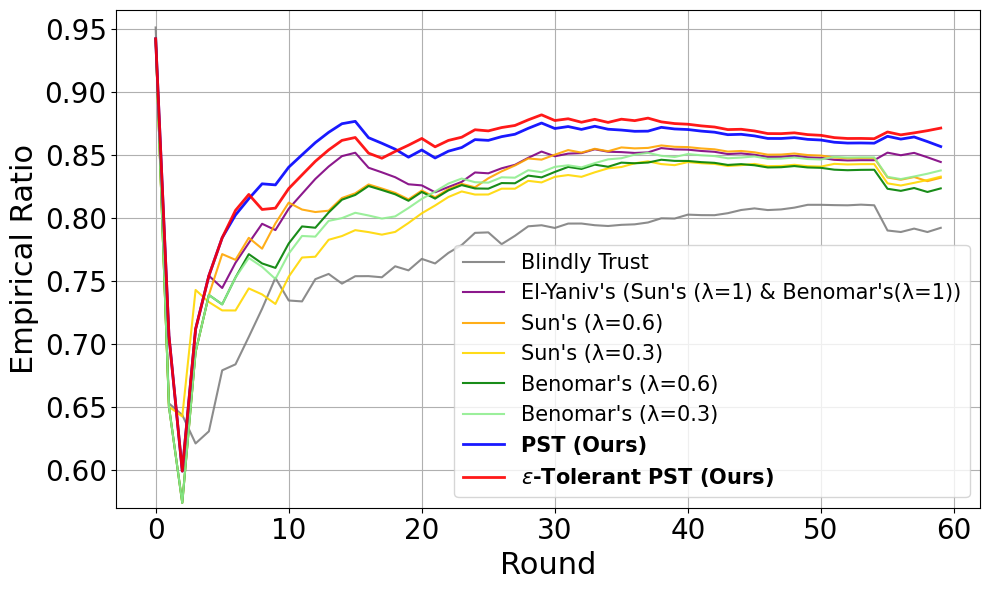

In [33]:
import numpy as np
import matplotlib.pyplot as plt

def plot_empirical_ratio(
    offline_rewards,
    online_rewards_dict,
    method_labels,
    highlight_methods=None,
    colors=None,
    title='Empirical Competitive Ratio'
):
    """
    Plot cumulative online/offline reward ratios for multiple methods.

    Parameters:
    - offline_rewards: 1D np.array of offline (oracle) rewards.
    - online_rewards_dict: dict {method_key: 1D np.array of online rewards}
    - method_labels: dict {method_key: label to display}
    - highlight_methods: set of method_keys to bold in legend
    - colors: dict {method_key: color name or code}
    - title: plot title
    """
    oracle_cumsum = np.cumsum(offline_rewards)
    epsilon_safe = 1e-8
    all_ratios = []

    plt.figure(figsize=(10, 6))

    for key, rewards in online_rewards_dict.items():
        ratio = np.cumsum(rewards) / (oracle_cumsum + epsilon_safe)
        all_ratios.append(ratio)
        plt.plot(
            ratio,
            label=method_labels.get(key, key),
            linewidth=2 if highlight_methods and key in highlight_methods else 1.5,
            color=colors.get(key, None),
            alpha=0.9
        )

    ymin = np.min(np.vstack(all_ratios))
    ymax = np.max(np.vstack(all_ratios)) + 0.01
    margin = 0.01 * (ymax - ymin)

    plt.xlabel('Round', fontsize=22)
    plt.ylabel('Empirical Ratio', fontsize=22)
    #plt.title(title, fontsize=16)
    plt.ylim(ymin - margin, ymax + margin)
    plt.grid(True)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.tight_layout()

    
    legend = plt.legend(fontsize=15, loc='lower right')
    for text in legend.get_texts():
        if highlight_methods and text.get_text() in [method_labels[m] for m in highlight_methods]:
            text.set_fontweight('bold')

    plt.show()
    

adjusted_predictions = adjust(error_level, predicted_first, actual_first)

# Collect all online strategies
online_rewards_dict = {}

# Blind
thresholds_BT = prediction_to_threshold_blindly_trust(L, U, adjusted_predictions)
online_rewards_dict['Blind'] = online_decision_making(df_filtered, thresholds_BT)

# El-Yaniv
thresholds_El = prediction_to_threshold_El_Yaniv(L, U, adjusted_predictions)
online_rewards_dict['El_Yaniv'] = online_decision_making(df_filtered, thresholds_El)

# Sun with λ=0.6 and λ=0.3
for lam in [0.6, 0.3]:
    key = f'Sun_{lam}'
    thresholds = prediction_to_threshold_Sun(L, U, adjusted_predictions, lam)
    online_rewards_dict[key] = online_decision_making(df_filtered, thresholds)

# Benomar with λ=0.6 and λ=0.3
for lam in [0.6, 0.3]:
    key = f'Benomar_{lam}'
    thresholds = prediction_to_threshold_Benomar(L, U, adjusted_predictions, lam)
    online_rewards_dict[key] = online_decision_making(df_filtered, thresholds)

# OMS (epsilon = 0) and epsilon-tolerant OMS
thresholds_OMS = prediction_to_threshold_epsilon_Tolerant(L, U, adjusted_predictions, lambda_epsilon_Tolerant, 0)
online_rewards_dict['OMS'] = online_decision_making(df_filtered, thresholds_OMS)

thresholds_ET = prediction_to_threshold_epsilon_Tolerant(L, U, adjusted_predictions, lambda_epsilon_Tolerant, eps)
online_rewards_dict['Epsilon_Tolerant'] = online_decision_making(df_filtered, thresholds_ET)

method_labels = {
    'Blind': 'Blindly Trust',
    'El_Yaniv': "El-Yaniv's (Sun's (λ=1) & Benomar's(λ=1))",
    'Sun_0.6': "Sun's (λ=0.6)",
    'Sun_0.3': "Sun's (λ=0.3)",
    'Benomar_0.6': "Benomar's (λ=0.6)",
    'Benomar_0.3': "Benomar's (λ=0.3)",
    'OMS': 'PST (Ours)',
    'Epsilon_Tolerant': '$\epsilon$-Tolerant PST (Ours)'
}

highlight_methods = {'OMS', 'Epsilon_Tolerant'}

colors = {
    'Blind': 'gray',
    'El_Yaniv': 'purple',
    'Sun_0.6': 'orange',
    'Sun_0.3': 'gold',
    'Benomar_0.6': 'green',
    'Benomar_0.3': 'lightgreen',
    'OMS': 'blue',
    'Epsilon_Tolerant': 'red'
}

plot_empirical_ratio(
    offline_rewards=offline_rewards,
    online_rewards_dict=online_rewards_dict,
    method_labels=method_labels,
    highlight_methods=highlight_methods,
    colors=colors,
    title='Empirical Competitive Ratio'
)

## Experiment 2

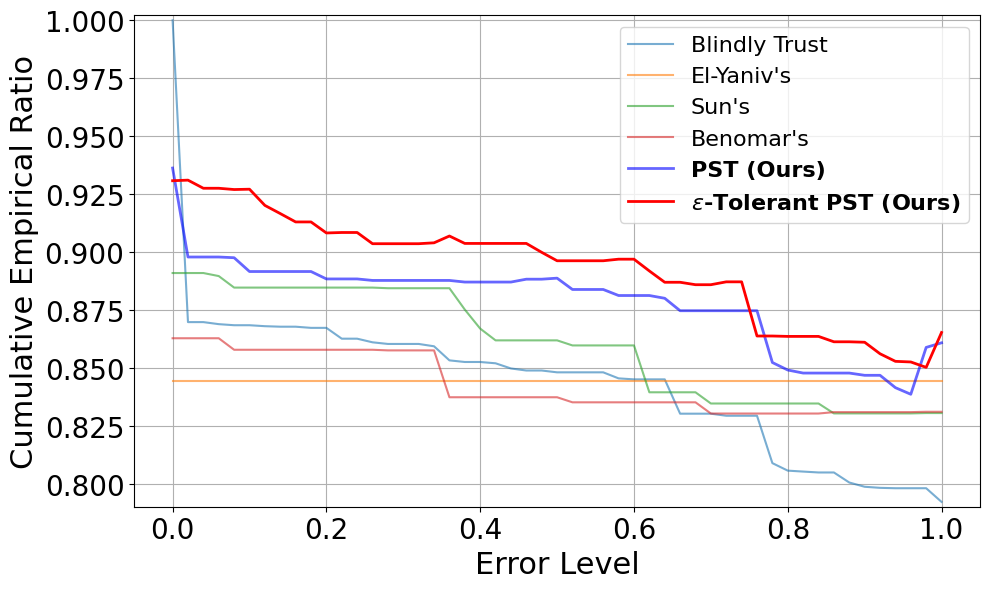

In [34]:
import numpy as np
import matplotlib.pyplot as plt

def error_level_vs_empirical_ratios(error_levels, df_filtered, predicted_first, actual_first, L, U,
                                     lambda_Sun=0.5, lambda_Benomar=0.5,
                                     lambda_epsilon_Tolerant=0.5, eps=1):
    
    ratios_BT = []
    ratios_El = []
    ratios_Sun = []
    ratios_Benomar = []
    ratios_ET = []
    ratios_OMS = []

    offline_rewards = offline_optimal(df_filtered)
    oracle_cumsum = np.cumsum(offline_rewards)
    epsilon_safe = 1e-8

    for error_level in error_levels:
        adjusted_predictions = adjust(error_level, predicted_first, actual_first)

        # Blindly Trust
        thresholds_BT = prediction_to_threshold_blindly_trust(L, U, adjusted_predictions)
        blind_rewards = online_decision_making(df_filtered, thresholds_BT)
        blind_ratio = np.sum(blind_rewards) / (oracle_cumsum[-1] + epsilon_safe)
        ratios_BT.append(blind_ratio)

        # El-Yaniv
        thresholds_El = prediction_to_threshold_El_Yaniv(L, U, adjusted_predictions)
        el_rewards = online_decision_making(df_filtered, thresholds_El)
        el_ratio = np.sum(el_rewards) / (oracle_cumsum[-1] + epsilon_safe)
        ratios_El.append(el_ratio)

        # Sun
        thresholds_Sun = prediction_to_threshold_Sun(L, U, adjusted_predictions, lambda_Sun)
        sun_rewards = online_decision_making(df_filtered, thresholds_Sun)
        sun_ratio = np.sum(sun_rewards) / (oracle_cumsum[-1] + epsilon_safe)
        ratios_Sun.append(sun_ratio)

        # Benomar
        thresholds_Benomar = prediction_to_threshold_Benomar(L, U, adjusted_predictions, lambda_Benomar)
        benomar_rewards = online_decision_making(df_filtered, thresholds_Benomar)
        benomar_ratio = np.sum(benomar_rewards) / (oracle_cumsum[-1] + epsilon_safe)
        ratios_Benomar.append(benomar_ratio)

        # Epsilon-Tolerant OMS (Ours)
        thresholds_ET = prediction_to_threshold_epsilon_Tolerant(L, U, adjusted_predictions, lambda_epsilon_Tolerant, eps)
        epsilon_rewards = online_decision_making(df_filtered, thresholds_ET)
        epsilon_ratio = np.sum(epsilon_rewards) / (oracle_cumsum[-1] + epsilon_safe)
        ratios_ET.append(epsilon_ratio)

        # OMS (Ours) with tolerance = 0
        thresholds_OMS = prediction_to_threshold_epsilon_Tolerant(L, U, adjusted_predictions, lambda_epsilon_Tolerant, eps=0)
        oms_rewards = online_decision_making(df_filtered, thresholds_OMS)
        oms_ratio = np.sum(oms_rewards) / (oracle_cumsum[-1] + epsilon_safe)
        ratios_OMS.append(oms_ratio)

    plt.figure(figsize=(10, 6))
    plt.plot(error_levels, ratios_BT, label='Blindly Trust', alpha=0.6, linewidth=1.5)
    plt.plot(error_levels, ratios_El, label="El-Yaniv's", alpha=0.6, linewidth=1.5)
    plt.plot(error_levels, ratios_Sun, label="Sun's", alpha=0.6, linewidth=1.5)
    plt.plot(error_levels, ratios_Benomar, label="Benomar's", alpha=0.6, linewidth=1.5)

    plt.plot(error_levels, ratios_OMS, label='PST (Ours)', color = 'blue', alpha=0.6, linewidth=2)
    plt.plot(error_levels, ratios_ET, label='$\epsilon$-Tolerant PST (Ours)', color='red', linewidth=2)

    all_ratios = np.vstack([ratios_BT, ratios_El, ratios_Sun, ratios_Benomar, ratios_ET, ratios_OMS])
    ymin, ymax = np.min(all_ratios), np.max(all_ratios)
    margin = 0.01 * (ymax - ymin)
    plt.ylim(ymin - margin, ymax + margin)

    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlabel('Error Level', fontsize=22)
    plt.ylabel('Cumulative Empirical Ratio', fontsize=22)
    #plt.title('Empirical Competitive Ratio vs Error Level')
    plt.grid(True)
    plt.tight_layout()
    legend = plt.legend(fontsize=16, title_fontsize=11, loc='upper right')
    for text in legend.get_texts():
        if highlight_methods and text.get_text() in [method_labels[m] for m in highlight_methods]:
            text.set_fontweight('bold')

    plt.show()
    
error_levels = np.linspace(0, 1, 51)
error_level_vs_empirical_ratios(error_levels, df_filtered, predicted_first, actual_first, L, U)